# Esercizio 3.1

## Soluzione esatta di Black-Scholes

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import math
import scipy
from scipy.special import erf
import os
import subprocess

In [2]:
S0, K = 100., 100.
T, r, sigma = 1., 0.1, 0.25

def N(x):
    return 0.5 * (1. + erf(x / np.sqrt(2.)))

def black_scholes(S0, K, T, r, sigma):
    d1 = 1./(sigma * np.sqrt(T)) * (np.log(S0 / K) + (r + (sigma**2) / 2.) * T)
    d2 = d1 - sigma * np.sqrt(T)
    C = S0 * N(d1) - K * np.exp(-r * T) * N(d2)
    P = S0 *(N(d1) - 1.) - K * np.exp(-r * T) * (N(d2)-1.)
    return C, P

call, put = black_scholes(S0, K, T, r, sigma)
print(" == BLACK-SCHOLES ==")
print("call: ", call)
print("put: ", put)

 == BLACK-SCHOLES ==
call:  14.975790778311286
put:  5.4595325819072364


## Call e Put per un'opzione europea con sampling diretto e discretizzato
I grafici mostrano i prezzi di call-option $C[S(0),0]$ e put-option $P[S(0),0]$ europee, con le loro incertezze, per due tipi di campionamento:
- sampling diretto del prezzo finale dell'asset $S(T)$ per un $GBM(r,\sigma^2)$
- sampling discretizzato di un $GBM(r,\sigma^2)$ del prezzo dell'asset, ottenuto dividendo l'intervallo $[0,T]$ in $10^2$ sotto-intervalli:  
$S(0)$, $S(t_1)$, $S(t_2)$, ... fino a $S(t_{100}=T=1)$

$S(t)$ segue un moto browniano geometrico $GBM(r,\sigma^2)$ con drift $r$ e volatilità $\sigma$.

1) Per campionare $S(T)$ in modo diretto basta quindi estrarre i valori di $W(T)$ da una PDF gaussiana con media $\mu=0$ e varianza $\sigma^2=T$:
 
$$S(T) = S(0) \exp\left[ \left(r-\frac{1}{2}\sigma^2\right)T+\sigma W(T)\right]$$

Per ottenere il prezzo di call dell'opzione europea $C[S(0),0]$ a tempo $t=0$, si applica un'evoluzione temporale inversa al profitto calcolato a $t=T$, cioè $\max(0, S(T)-K)$. Si ha:

$$C\left[S(0),0\right] = e^{-rT}\max(0, S(T)-K)$$

La procedura per calcolare il prezzo di put è la stessa ma l'evoluzione temporale viene applicata questa volta a $\max(0, K - S(T))$, ottenendo:

$$P\left[S(0),0\right] = e^{-rT}\max(0, K - S(T))$$

2) Si può ricavare $S(T)$ campionando l'intera traiettoria del moto browniano geometrico; dividendo l'intervallo temporale $[0,T]$ in $100$ sotto intervalli si va a campionare il prezzo del titolo per ogni step temporale:

$$S(t_{i+1}) = S(t_i) \exp\left[ \left(r-\frac{1}{2}\sigma^2\right)(t_{i+1}-t_i)
    +\sigma Z_{i+1}\sqrt{t_{i+1}-t_i}\right]$$
    
dove $Z_{i+1}$ è una variabile aleatoria estratta da una PDF Gaussiana con $\mu=0$ e $\sigma=1$. Una volta ottenuto $S(T)$ (cioè simulati tutti i 100 passi) si applicano le stesse formule del direct sampling per calcolare call e put. 

Ho utilizzato il blocking method con un numero di lanci pari a $M = 10^5$, mentre il numero di blocchi è $N = 250$. Tutte le simulazioni mostrano un'ottima convergenza al valore teorico; utilizzando il discretized sampling si ottengono risultati più precisi (l'incertezza sul valor medio per blocco è minore).

In [3]:
arguments = ""
subprocess.run("make clean", shell=True, stdout=subprocess.PIPE)
subprocess.run('make esegui ARGS="%s"' % arguments, shell=True)

CompletedProcess(args='make esegui ARGS=""', returncode=0)

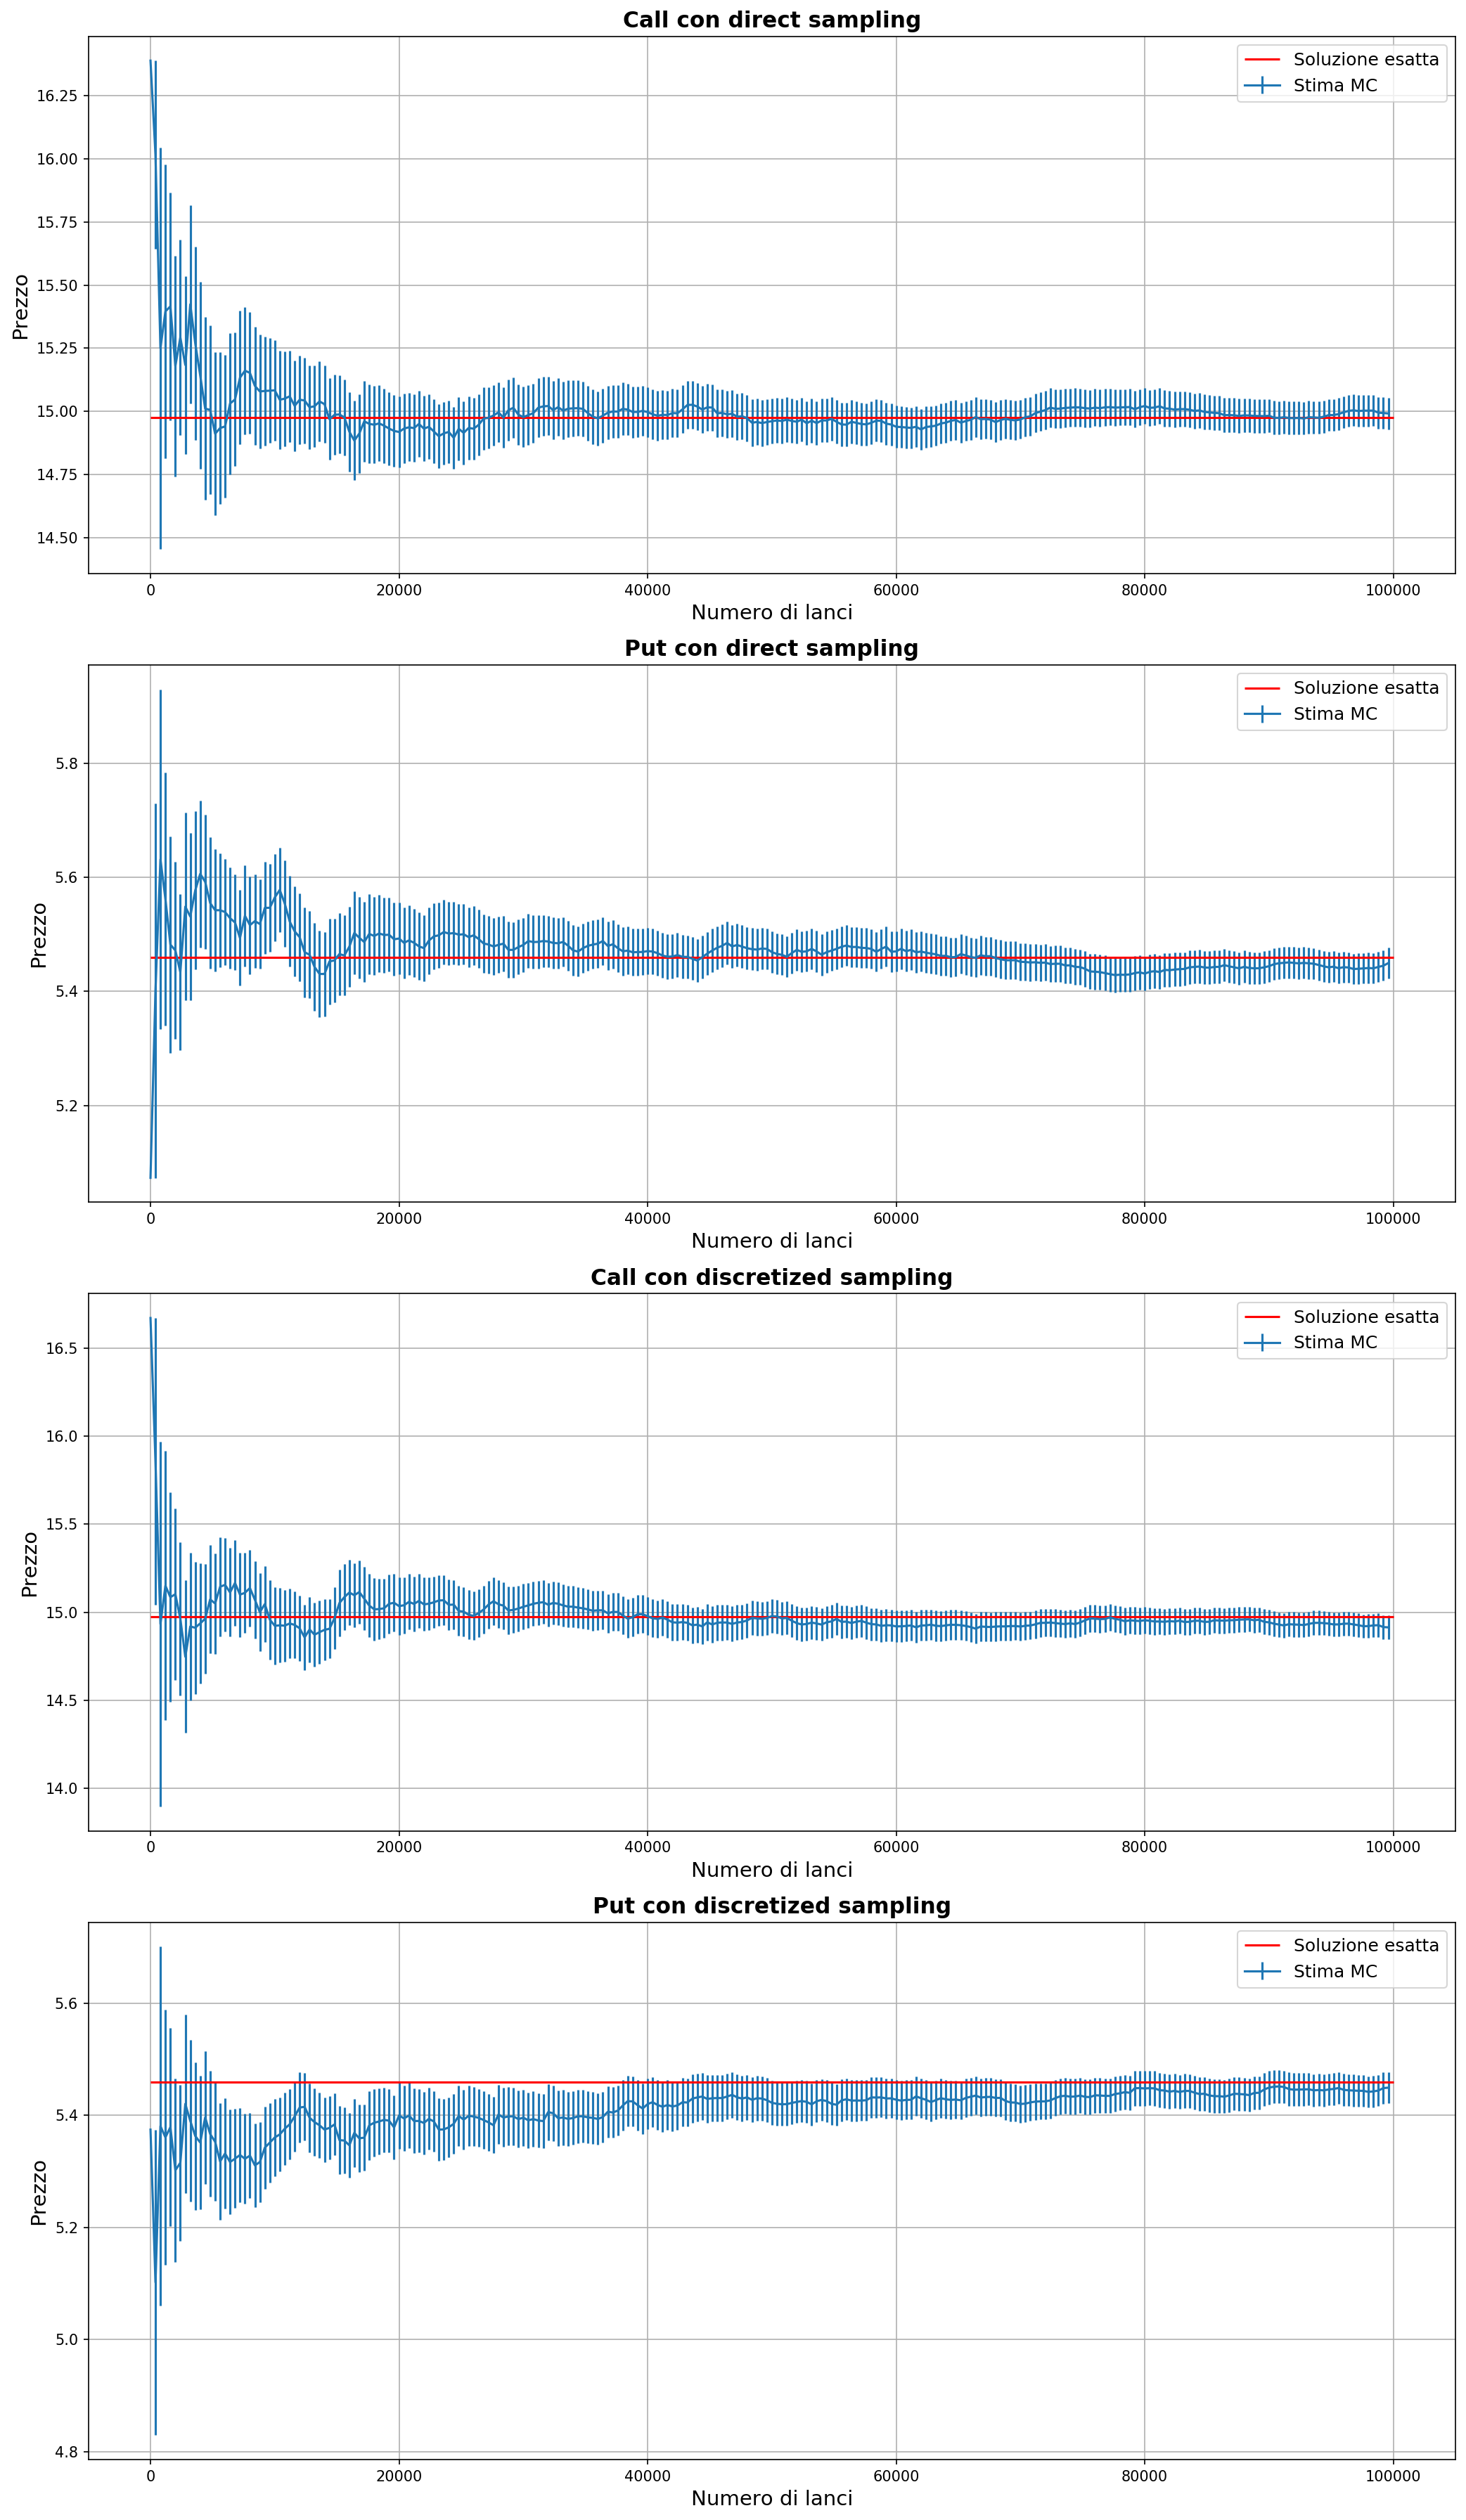

In [4]:
M = 10**5               # Numero di lanci
N = 250                 # Numero di blocchi
L = int(M/N)            # Numero di lanci in ogni blocc, M deve essere multiplo di N
x = np.arange(N)*L    # [0,L,2L,...,(N-1)L]

fig = plt.figure(figsize=(14, 24) , dpi=150)
gnames = ['Call con direct sampling', 'Put con direct sampling',           
          'Call con discretized sampling', 'Put con discretized sampling']  # Nomi dei grafici
fnames = ['fileC.txt','fileP.txt','fileC2.txt','fileP2.txt']
labnames = ['U/N', 'C/N', r'$\chi /N$', 'M/N'] # Labels asse y
thvalues = [call, put, call, put]

for i in range(4):
    ax = fig.add_subplot(4, 1, i+1)
    y, err = ((np.genfromtxt(fnames[i], usecols=j, autostrip=True)) for j in range(2))
    ax.errorbar(x, y, yerr=err, label='Stima MC')
    ax.hlines(thvalues[i], 0, 100000, colors='r', linestyles='solid', label='Soluzione esatta')
    ax.set_xlabel('Numero di lanci', fontsize=14)
    ax.set_ylabel('Prezzo', fontsize=14)
    ax.set_title(gnames[i], fontsize=15, fontweight='bold')
    ax.grid(True)
    ax.legend(loc=1, prop={'size': 12})

fig.tight_layout()
plt.show()